# Rule of Law and Network Topologies among Elites implicated in Tax Evasion (ICIJ Data)

Goal here is, understanding how the network structure of high-end tax evasion in developing countries differs across countries. Specifically, we are interested in how network structure correlates with the level of institutional quality in the country extending the work of Chang et al. (2023).

Owes a lot to especially this paper and the ICIJ:
* Ho-Chun Herbert Chang, Brooke Harrington, Feng Fu, Daniel N Rockmore, Complex systems of secrecy: the offshore networks of oligarchs, PNAS Nexus, Volume 2, Issue 3, March 2023, pgad051, https://doi.org/10.1093/pnasnexus/pgad051
* https://offshoreleaks.icij.org/

Description of the dataset (taken from Chang et al. 2023):
* Officers—Individual people who are related to entities. We
further split this into three classes. Beneficiaries: The direct
recipients and benefits of offshore accounts; Nominees:
Individuals who are instated to manage these accounts;
(Officer) Intermediaries: Those employed to set-up these
accounts.
* Entities—The businesses set-up for beneficiaries. These can
be corporations, foundations, or trusts.
* Intermediaries—Companies that help set-up these offshore
entities.
* Addresses—Addresses registered to the three other types of
nodes named above.

Their results were, summarised briefly, as follows:
1.	Asset Diversification:
Elites in highly corrupt countries tend to spread their assets across multiple offshore financial centers, rather than concentrating them in a single location, reducing risk.

2.	Identity Concealment in High-Confiscation Contexts:
In countries where the risk of government asset confiscation is high—due either to limited civil rights or exceptionally effective law enforcement—elites predominantly use identity-concealing mechanisms such as bearer instruments and nominee arrangements.

3.	Use of Blacklisted Offshore Centers Under Dual Risks:
Where countries face both high levels of corruption and elevated risks of asset confiscation, elites are more likely to use blacklisted offshore financial centers. 

Since this is too broad a topic to focus completely on, I'll choose to concentrate on the following question for this network analysis

### Research Topic: Rule of Law and Network Typology

Premise: Political conditions, particularly the strength of the rule of law, influence how elites structure their offshore asset networks. The degree distribution, therefore, is tacitly assumed to indicate something about the level of strategic coordination and organization among the actors in the network.

To focus the assignment a bit, we'll try to investigate a few countries in Africa meeting two criteria: 1) a reasonable amount of officers tied to it, and contingent upon 1) we then choose a set of countries so we maximise the variation in the Rule of Law indices taken from the World Bank's Governance Project.

Network Metric Links: In countries with weak rule-of-law indicators, one might observe network properties closer to those of an Erdos-Renyi random graph (i.e., more homogenous and less organized connectivity), whereas stronger rule-of-law conditions might be associated with more deliberate, centralized networks.

Testable Prediction: A comparative analysis should reveal that lower Rule of Law indices correlate with more random network structures (e.g., uniform degree distribution), while higher indices correlate with networks that have identifiable hubs and higher clustering.


### Results

Unfortunately, the results didn't reveal any association, but this also owes to fault of my own here. The data was incredibly hard to preprocess because it's just a difficult network structure, so that ate up way too much of the time, and I ended up running out of it when the assignment came due. This topic deserves a lot more work,and I unfortunately did not grasp the extent of this project before it was too late, and should likely have chosen another topic instead. 

By the way of that preamble, here are some very preliminary results, that one should not put a lot of confidence in:

* Network structures between different developing countries in Africa. This is particularly striking in terms of the number of nodes, the types of nodes as well as the number of nodes they each have (although it would have been a lot nicer to specify our relations a lot more, looking at e.g. metrics that were normalised per capita or the like) 
    * Kenya is for example an extreme example where the network typology is essentially fully composed of entities with very few officers binding it all together
* Rule of law indicies, however, seem to be entirely uncorrelated with any of it... More entries, a well-specified regression formula would definitely have improved the precision, so we might have had the abiility to revela something there. Joining those datasets in would just have required far too much work, unfortunately.
* All of htem essentially fit a power-law distribution, which is consistent with the findings in Chung et al. (2023). But unfortunately in terms of the question posed here, there's at the same time nothing that's correlated in terms of the rule of law index



In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import powerlaw
import random

from collections import defaultdict
import scipy.stats as stats

# Set plot style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Data Loading

Load the ICIJ offshore leaks data.

In [2]:
icij_data_path = Path("datasets/ICIJ/data")

addresses_path = icij_data_path / "nodes-addresses.csv"
officers_path = icij_data_path / "nodes-officers.csv"
entities_path = icij_data_path / "nodes-entities.csv"
intermediaries_path = icij_data_path / "nodes-intermediaries.csv"
others_path = icij_data_path / "nodes-others.csv"
relationships_path = icij_data_path / "relationships.csv"

officers_df = pd.read_csv(officers_path)
entities_df = pd.read_csv(entities_path)
intermediaries_df = pd.read_csv(intermediaries_path)
others_df = pd.read_csv(others_path)
relationships_df = pd.read_csv(relationships_path)

print(f"Officers: {officers_df.shape[0]} rows")
print(f"Entities: {entities_df.shape[0]} rows")
print(f"Intermediaries: {intermediaries_df.shape[0]} rows")
print(f"Relationships: {relationships_df.shape[0]} rows")

/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_16488/1775243572.py:11: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  entities_df = pd.read_csv(entities_path)
/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_16488/1775243572.py:14: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  relationships_df = pd.read_csv(relationships_path)


Officers: 771315 rows
Entities: 814344 rows
Intermediaries: 26768 rows
Relationships: 3339267 rows


In [6]:
intermediaries_df.head()

node_id                        name     status internal_id  \
0  11000001     MICHAEL PAPAGEORGE, MR.     ACTIVE       10001   
1  11000002          CORFIDUCIA ANSTALT     ACTIVE       10004   
2  11000003               DAVID, RONALD  SUSPENDED       10014   
3  11000004  DE  BOUTSELIS, JEAN-PIERRE  SUSPENDED       10015   
4  11000005    THE LEVANT LAWYERS (TLL)     ACTIVE       10029   

                                             address      countries  \
0  MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...   South Africa   
1                                                NaN  Liechtenstein   
2                                                NaN         Monaco   
3                                                NaN        Belgium   
4                                                NaN        Lebanon   

  country_codes       sourceID  \
0           ZAF  Panama Papers   
1           LIE  Panama Papers   
2           MCO  Panama Papers   
3           BEL  Panama Papers   
4           LBN  Panama Papers   

                                       valid_until note  
0  The Panama Papers  data is current through 2015  NaN  
1  The Panama Papers  data is current through 2015  NaN  
2  The Panama Papers  data is current through 2015  NaN  
3  The Panama Papers  data is current through 2015  NaN  
4  The Panama Papers  data is current through 2015  NaN

In [7]:
entities_df.head()

node_id                                         name  \
0  10000001     TIANSHENG INDUSTRY AND TRADING CO., LTD.   
1  10000002  NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.   
2  10000003                           HOTFOCUS CO., LTD.   
3  10000004              SKY-BLUE GIFTS & TOYS CO., LTD.   
4  10000005         FORTUNEMAKER INVESTMENTS CORPORATION   

                                 original_name former_name jurisdiction  \
0     TIANSHENG INDUSTRY AND TRADING CO., LTD.         NaN          SAM   
1  NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.         NaN          SAM   
2                           HOTFOCUS CO., LTD.         NaN          SAM   
3              SKY-BLUE GIFTS & TOYS CO., LTD.         NaN          SAM   
4         FORTUNEMAKER INVESTMENTS CORPORATION         NaN          SAM   

  jurisdiction_description company_type  \
0                    Samoa          NaN   
1                    Samoa          NaN   
2                    Samoa          NaN   
3                    Samoa          NaN   
4                    Samoa          NaN   

                                             address  internal_id  \
0  ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...    1001256.0   
1  ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...    1001263.0   
2  ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...    1000896.0   
3  ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...    1000914.0   
4  LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...    1001266.0   

  incorporation_date  ... struck_off_date dorm_date         status  \
0        23-MAR-2006  ...     15-FEB-2013       NaN      Defaulted   
1        27-MAR-2006  ...     15-FEB-2014       NaN      Defaulted   
2        10-JAN-2006  ...     15-FEB-2012       NaN      Defaulted   
3        06-JAN-2006  ...     15-FEB-2009       NaN      Defaulted   
4        19-APR-2006  ...     15-FEB-2008       NaN  Changed agent   

  service_provider  ibcRUC country_codes  countries       sourceID  \
0  Mossack Fonseca   25221           HKG  Hong Kong  Panama Papers   
1  Mossack Fonseca   25249           HKG  Hong Kong  Panama Papers   
2  Mossack Fonseca   24138           HKG  Hong Kong  Panama Papers   
3  Mossack Fonseca   24012           HKG  Hong Kong  Panama Papers   
4  Mossack Fonseca  R25638           HKG  Hong Kong  Panama Papers   

                                      valid_until note  
0  The Panama Papers data is current through 2015  NaN  
1  The Panama Papers data is current through 2015  NaN  
2  The Panama Papers data is current through 2015  NaN  
3  The Panama Papers data is current through 2015  NaN  
4  The Panama Papers data is current through 2015  NaN  

[5 rows x 21 columns]

## Country Selection and Rule of Law Data

We'll focus on 5 African countries with varying levels of institutional quality.

In [43]:
countries = {
    "ZAF": {"name": "South Africa", "rule_of_law": 0.06},  
    "NGA": {"name": "Nigeria", "rule_of_law": -0.88},      
    "EGY": {"name": "Egypt", "rule_of_law": -0.41},        
    "KEN": {"name": "Kenya", "rule_of_law": -0.42},        
    "GHA": {"name": "Ghana", "rule_of_law": 0.07},         
    "MAR": {"name": "Morocco", "rule_of_law": 0.04},       
    "TZA": {"name": "Tanzania", "rule_of_law": -0.44},     
    "CIV": {"name": "Côte d'Ivoire", "rule_of_law": -0.63}, 
    "AGO": {"name": "Angola", "rule_of_law": -1.05},       
    "SEN": {"name": "Senegal", "rule_of_law": 0.14}        
}

country_codes = list(countries.keys())
officers_by_country = {}

for country_code in country_codes:
    country_officers = officers_df[officers_df["country_codes"].str.contains(country_code, na=False)]
    officers_by_country[country_code] = country_officers
    print(f"{countries[country_code]['name']} ({country_code}): {len(country_officers)} officers")

South Africa (ZAF): 3648 officers
Nigeria (NGA): 710 officers
Egypt (EGY): 952 officers
Kenya (KEN): 526 officers
Ghana (GHA): 127 officers
Morocco (MAR): 309 officers
Tanzania (TZA): 117 officers
Côte d'Ivoire (CIV): 106 officers
Angola (AGO): 305 officers
Senegal (SEN): 48 officers


A highly varying number of officers already...

<Axes: title={'center': 'Number of officers by country'}>

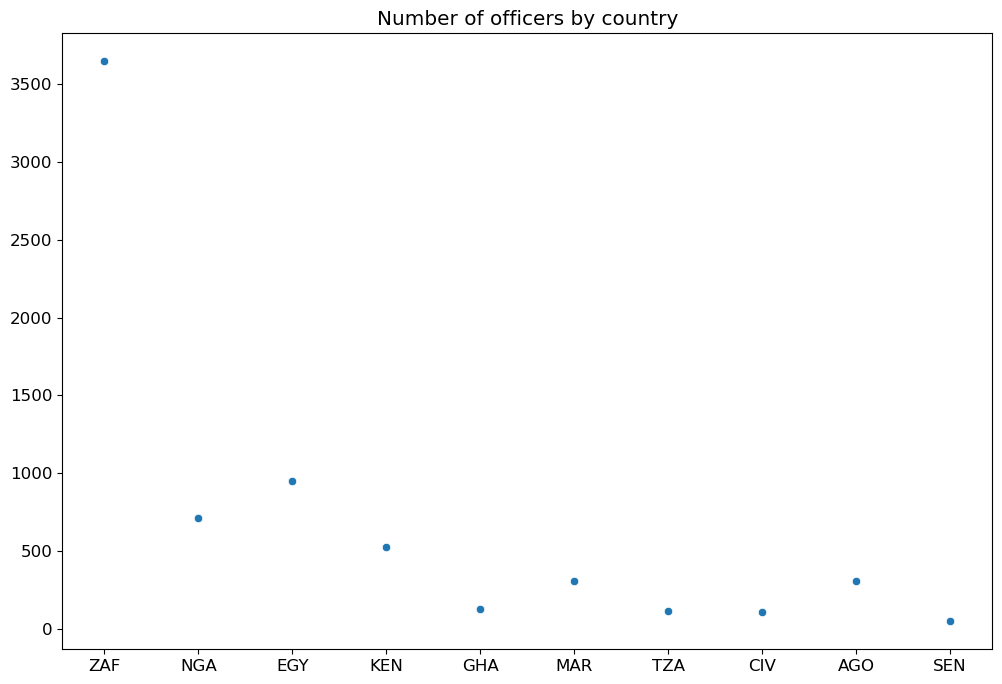

In [44]:
plt.title("Number of officers by country")
sns.scatterplot(
    x=officers_by_country.keys(),
    y=[len(officers) for officers in officers_by_country.values()],
)

## Network Construction

Create separate networks for each country.

In [ ]:
def create_country_network(country_code, officers_df, entities_df, intermediaries_df, relationships_df):
    country_officers = officers_by_country[country_code]
    
    G = nx.Graph()
    
    officer_nodes = set(country_officers["node_id"])
    for _, row in country_officers.iterrows():
        G.add_node(row["node_id"], node_type="officer", **row.to_dict())
    
    officer_relationships = relationships_df[
        (relationships_df["node_id_start"].isin(officer_nodes)) | 
        (relationships_df["node_id_end"].isin(officer_nodes))
    ]
    
    related_entities = set()
    related_intermediaries = set()
    
    entity_nodes = set(entities_df['node_id'].values)
    intermediary_nodes = set(intermediaries_df['node_id'].values)

    for _, row in officer_relationships.iterrows():
        if row["node_id_start"] in officer_nodes:
            if row["node_id_end"] in entity_nodes:
                related_entities.add(row["node_id_end"])
            elif row["node_id_end"] in intermediary_nodes:
                related_intermediaries.add(row["node_id_end"])
        elif row["node_id_end"] in officer_nodes:
            if row["node_id_start"] in entity_nodes:
                related_entities.add(row["node_id_start"])
            elif row["node_id_start"] in intermediary_nodes:
                related_intermediaries.add(row["node_id_start"])
    
    for entity_id in related_entities:
        entity_data = entities_df[entities_df["node_id"] == entity_id]
        if not entity_data.empty:
            G.add_node(entity_id, node_type="entity", **entity_data.iloc[0].to_dict())
    
    for intermediary_id in related_intermediaries:
        intermediary_data = intermediaries_df[intermediaries_df["node_id"] == intermediary_id]
        if not intermediary_data.empty:
            G.add_node(intermediary_id, node_type="intermediary", **intermediary_data.iloc[0].to_dict())
    
    for _, row in officer_relationships.iterrows():
        if (row["node_id_start"] in G.nodes) and (row["node_id_end"] in G.nodes):
            G.add_edge(row["node_id_start"], row["node_id_end"], **row.to_dict())
    
    return G

country_networks = {}
for country_code in country_codes:
    print(f"Creating network for {countries[country_code]['name']}...")
    country_networks[country_code] = create_country_network(
        country_code, officers_df, entities_df, intermediaries_df, relationships_df
    )
    
    G = country_networks[country_code]
    print(f"  Nodes: {G.number_of_nodes()}")
    print(f"  Edges: {G.number_of_edges()}")
    
    node_types = defaultdict(int)
    for _, data in G.nodes(data=True):
        if "node_type" in data:
            node_types[data["node_type"]] += 1
    print(f"  Node types: {dict(node_types)}")
    
    largest_cc = max(nx.connected_components(G), key=len)
    print(f"  Largest connected component: {len(largest_cc)} nodes")
    print()

: 

## Network Visualization

Visualize the networks for each country.

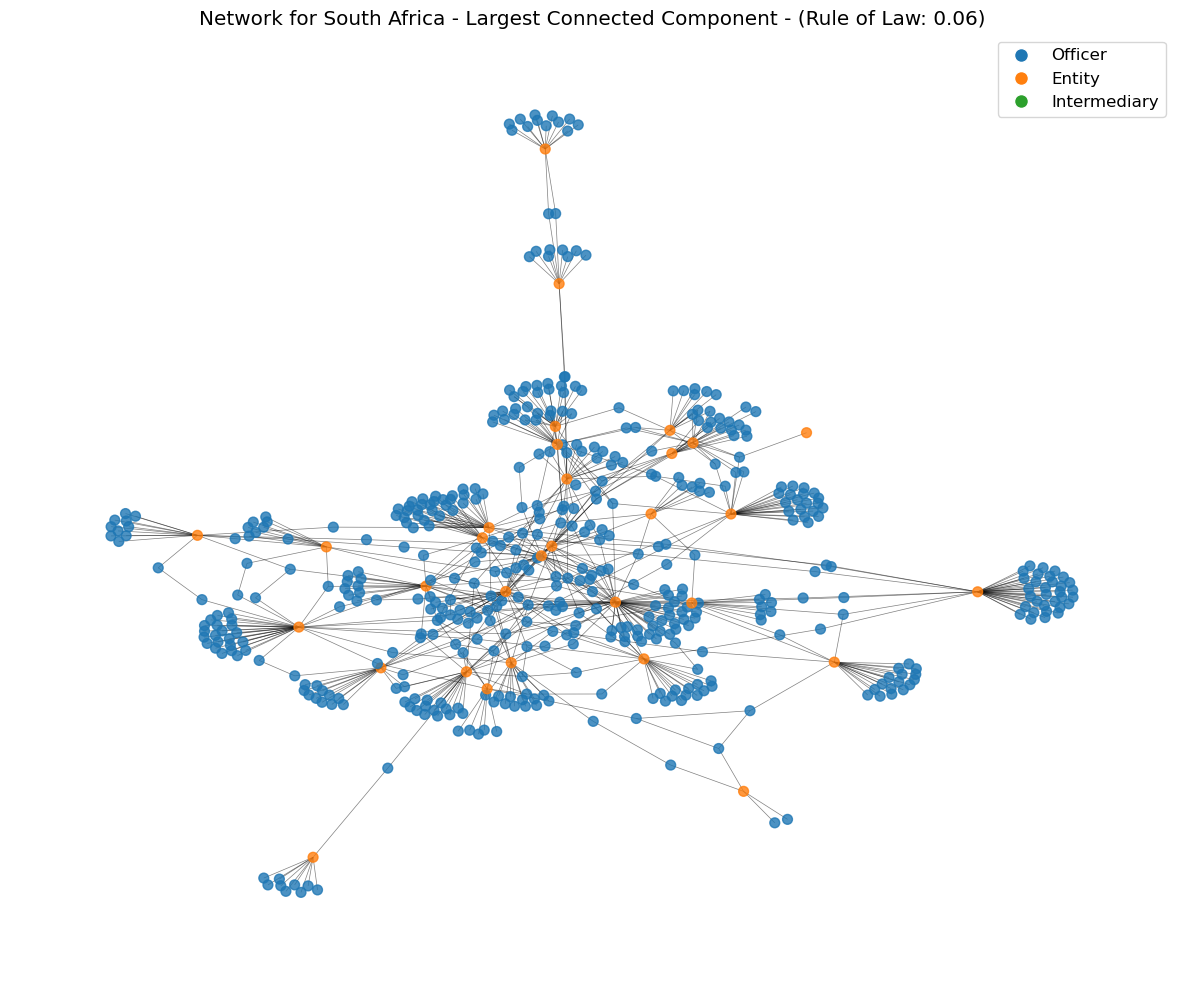

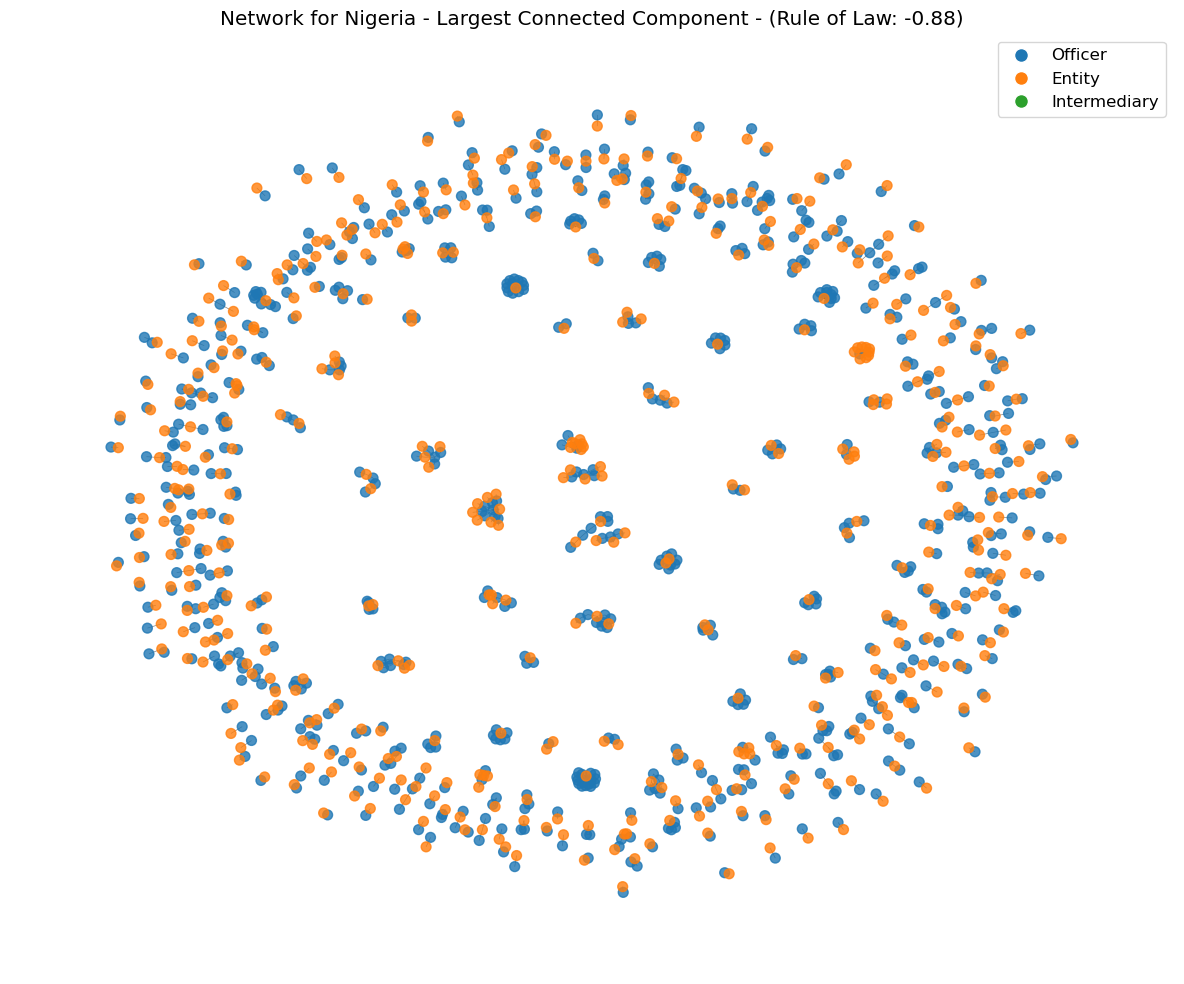

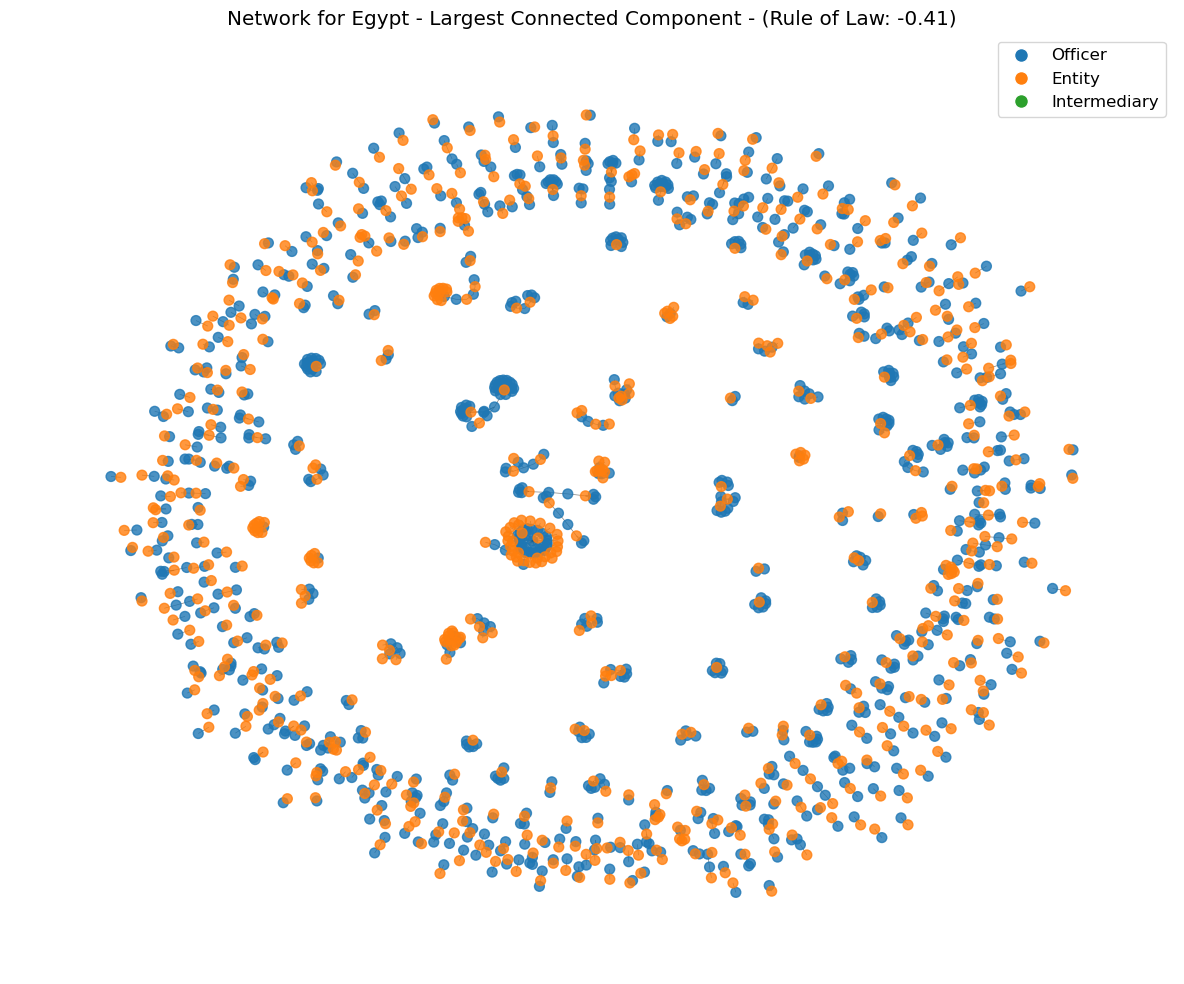

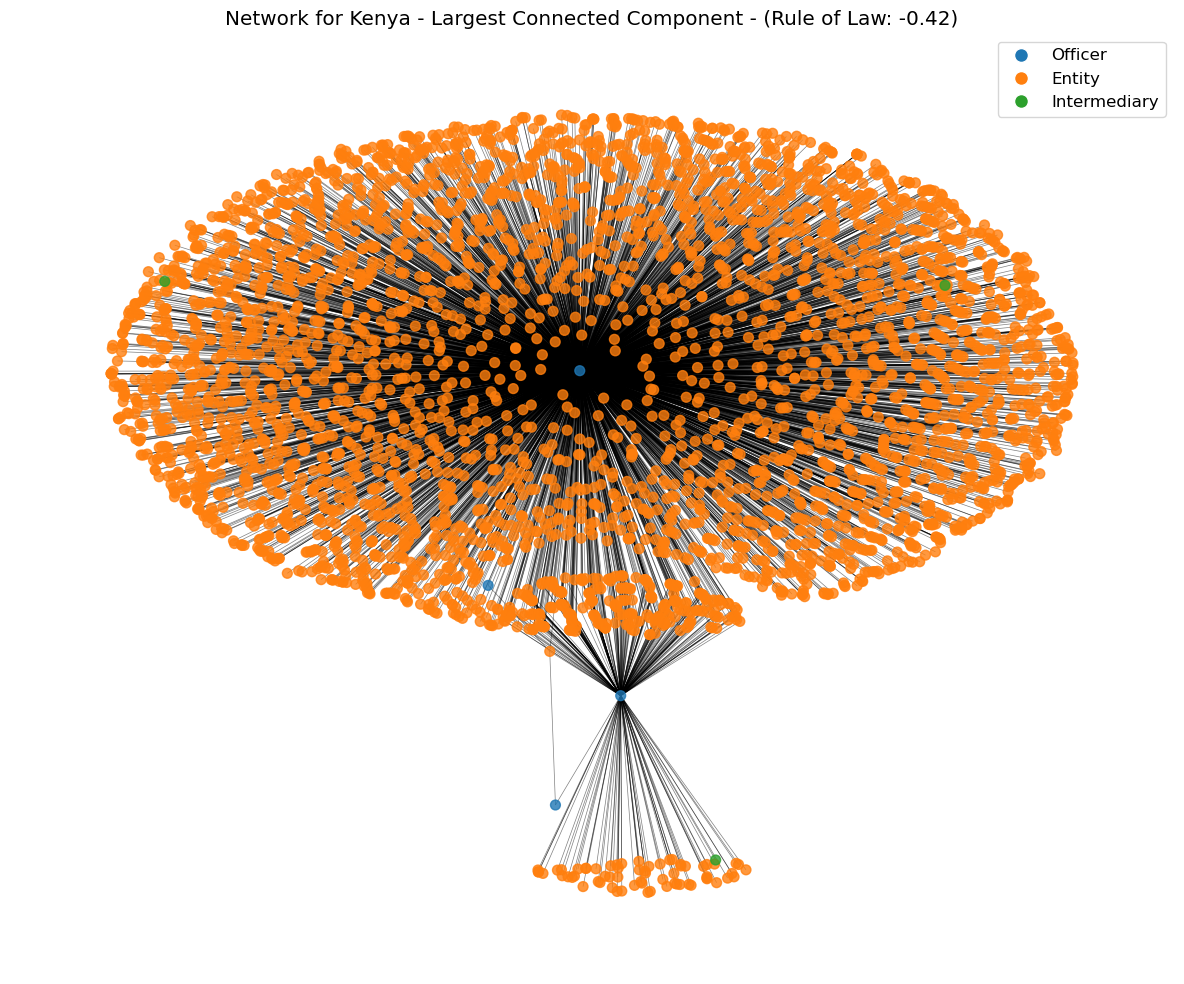

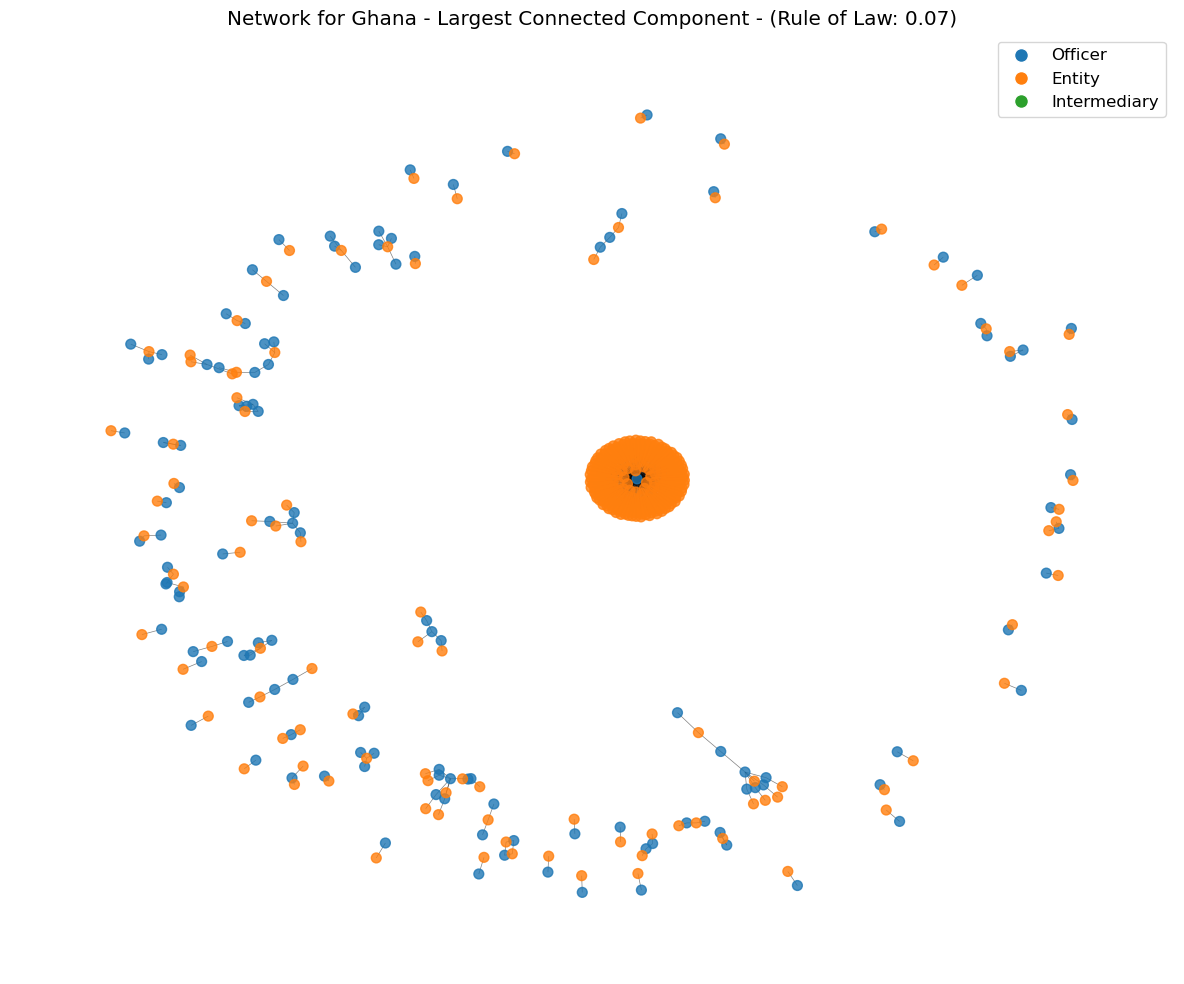

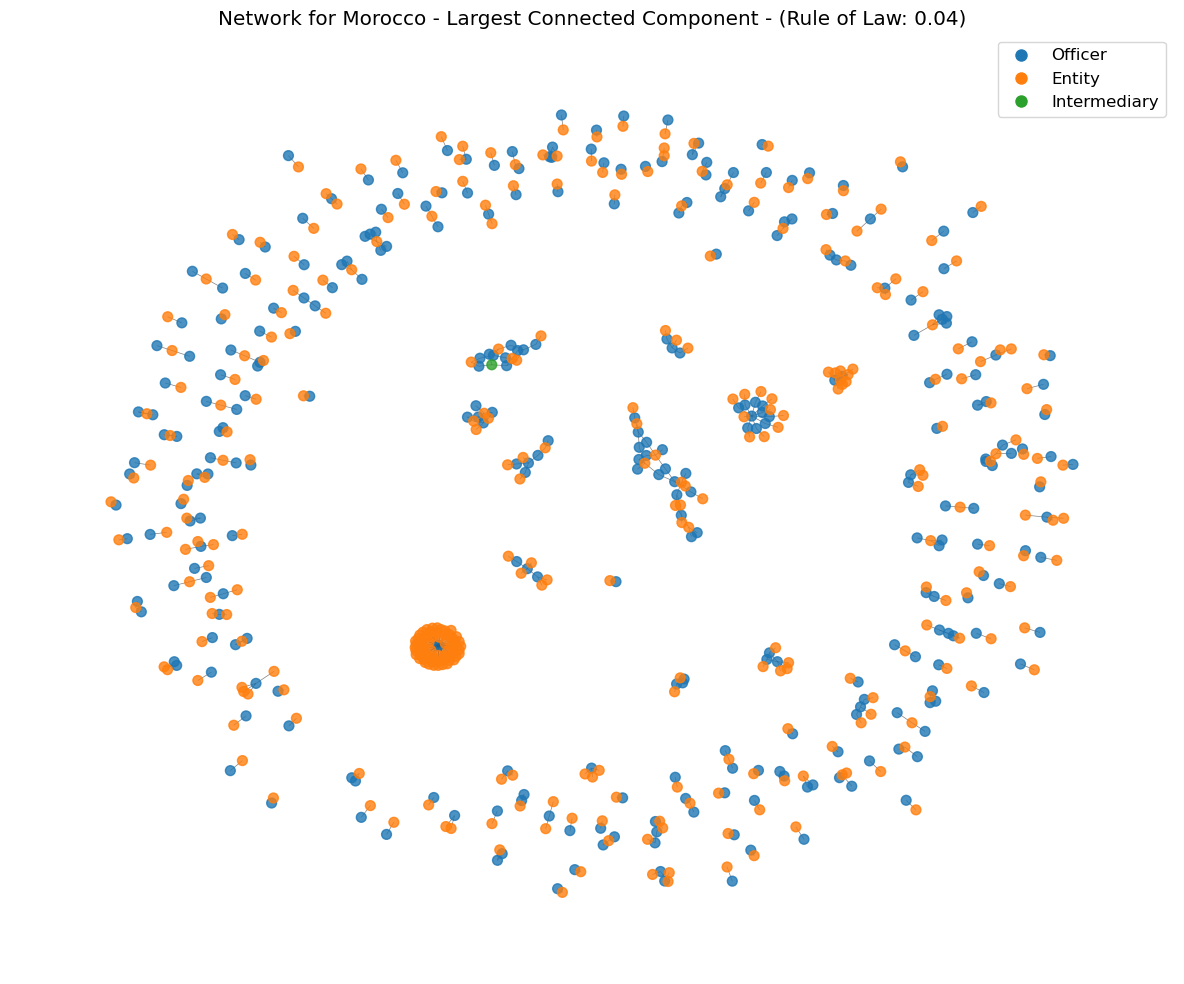

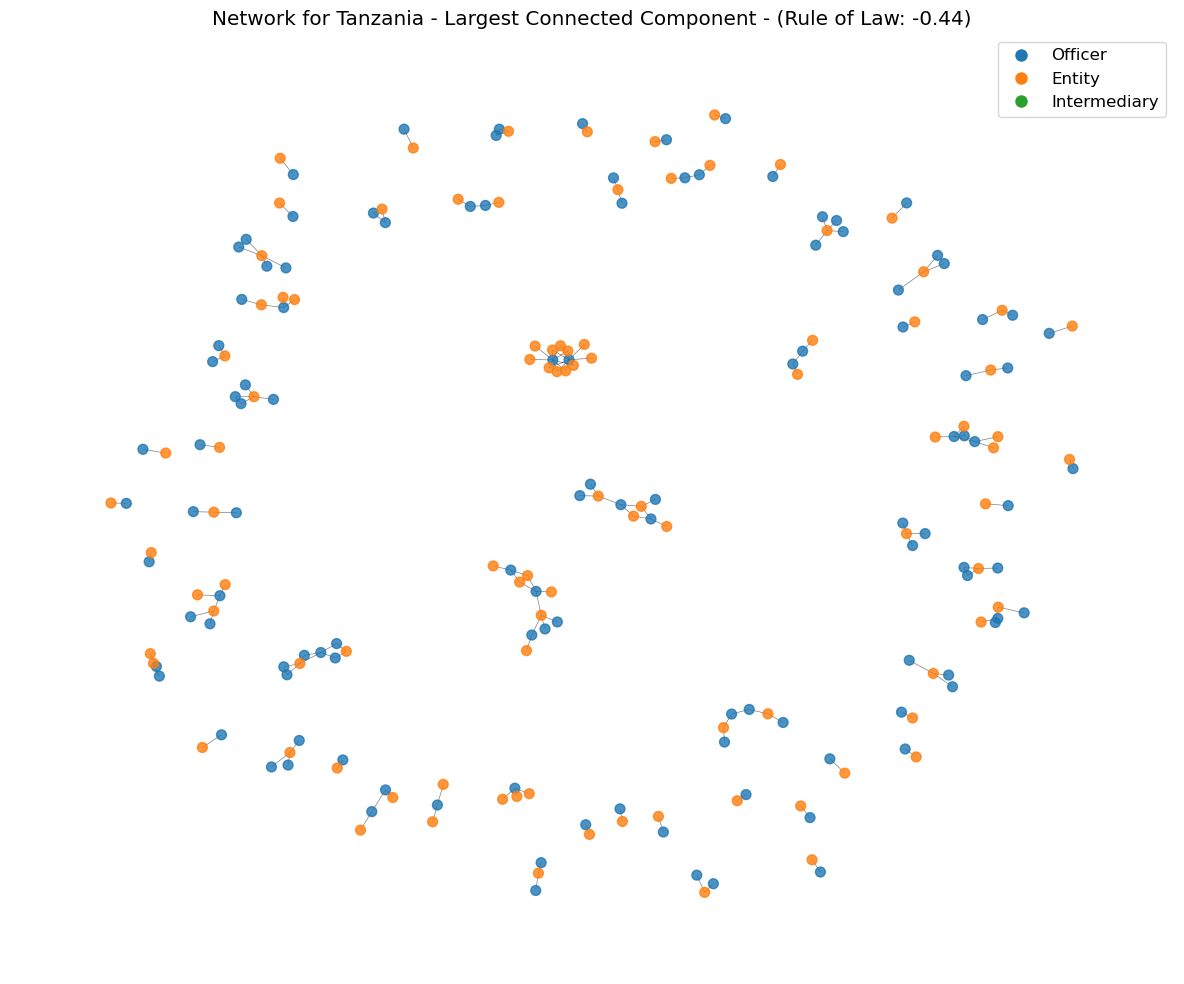

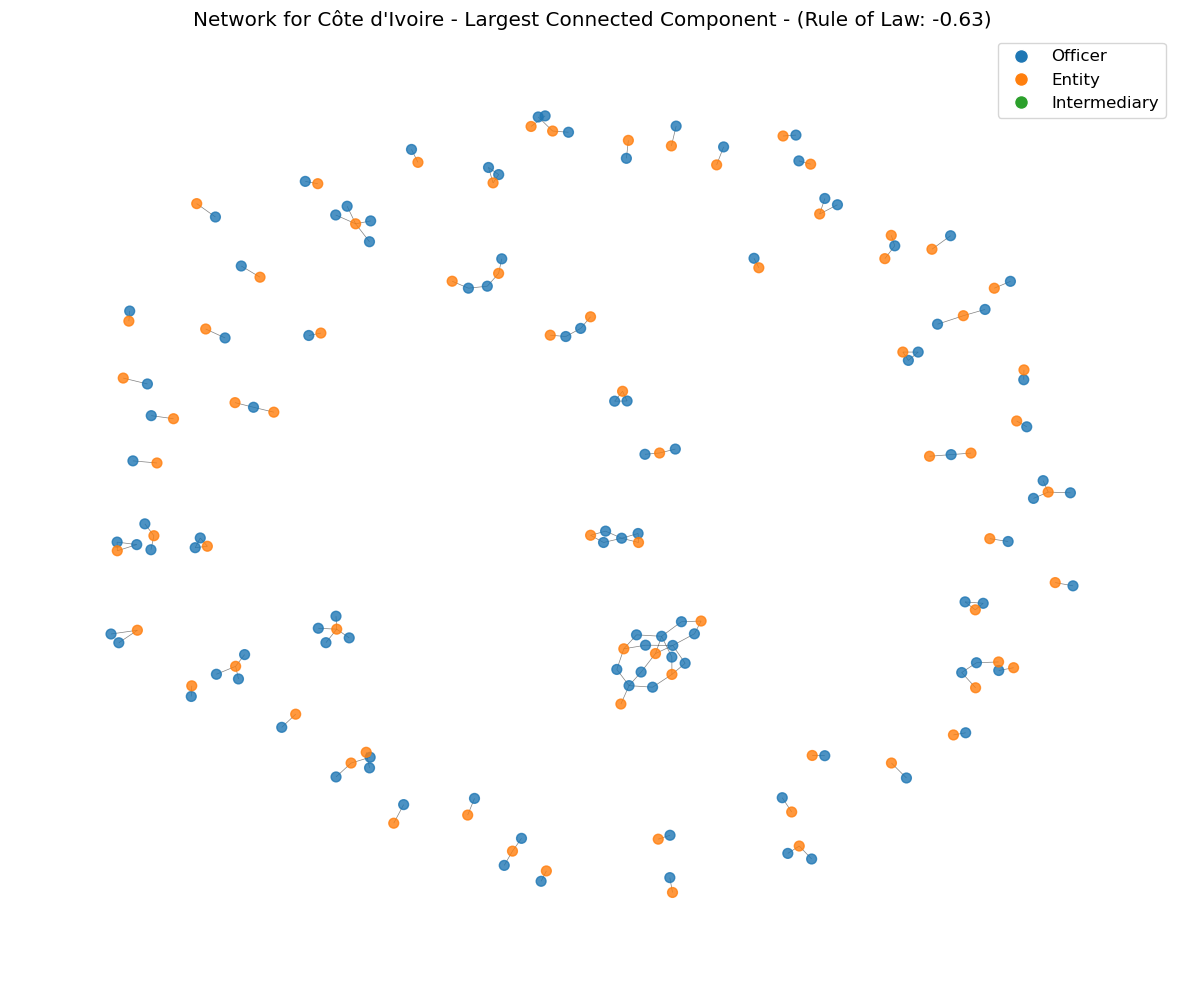

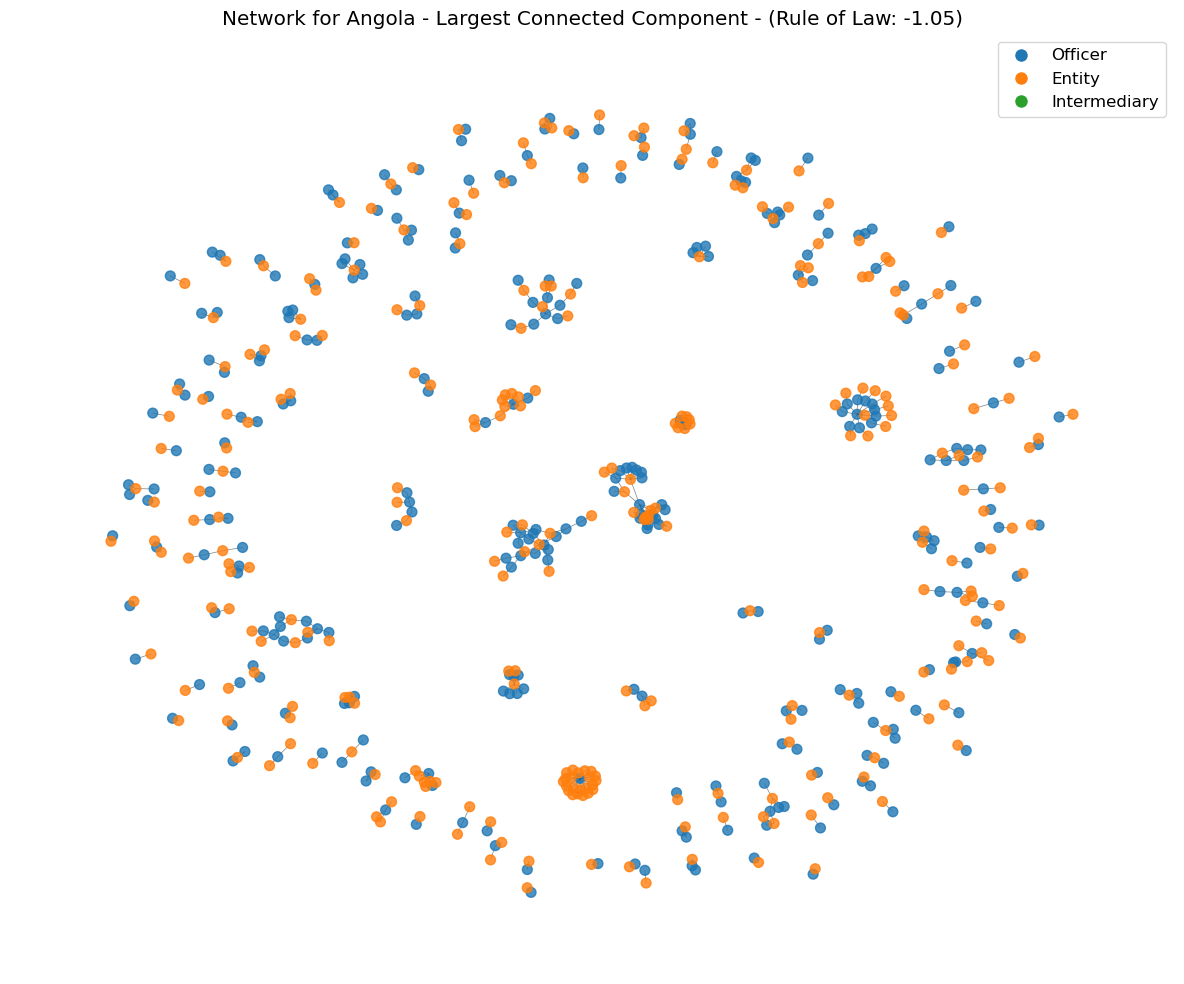

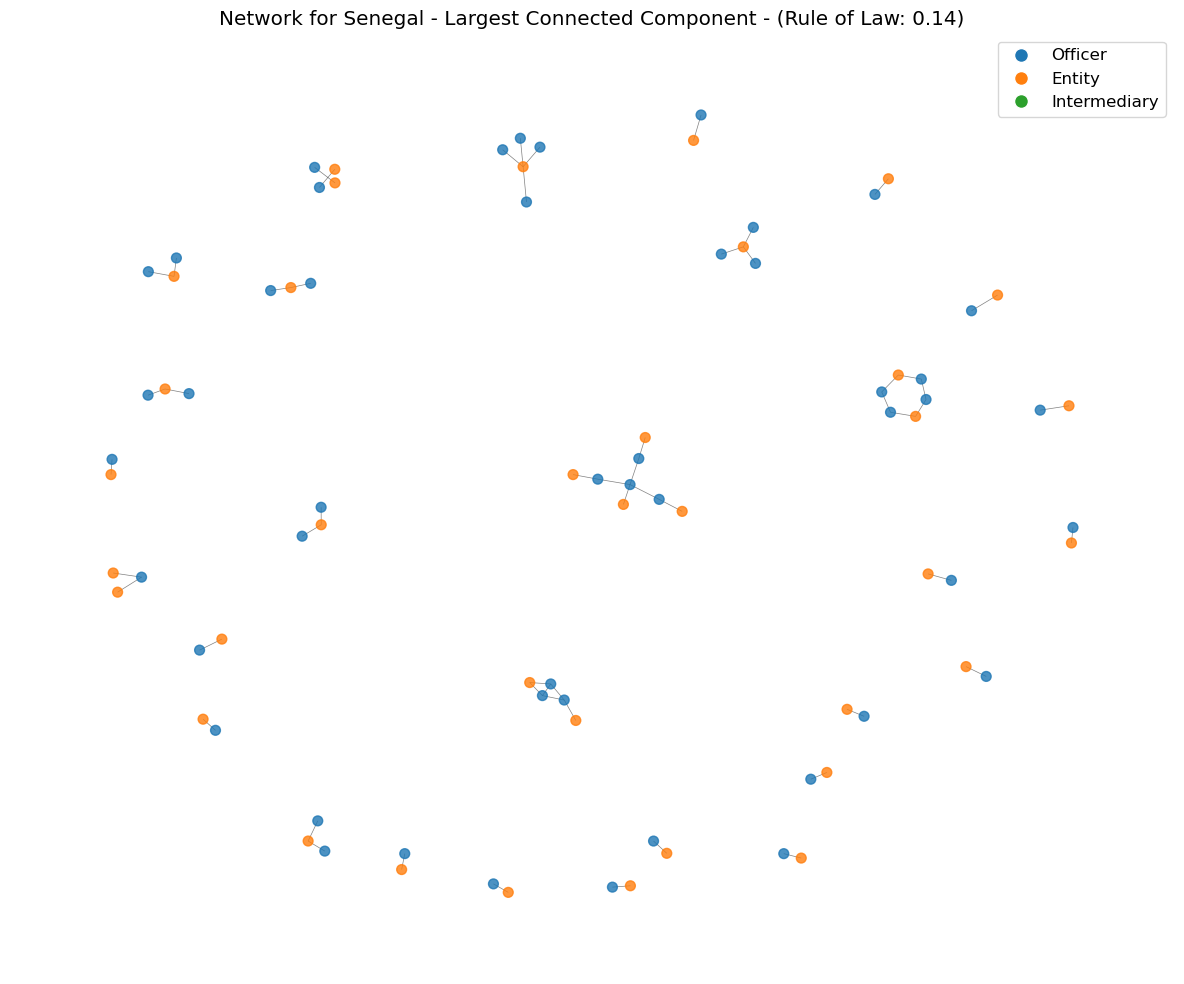

In [32]:
def visualize_network(G, title, max_nodes=5000):
    if G.number_of_nodes() > max_nodes:
        largest_cc = max(nx.connected_components(G), key=len)
        G_vis = G.subgraph(largest_cc).copy()
        if G_vis.number_of_nodes() > max_nodes:
            nodes = list(G_vis.nodes())
            sampled_nodes = random.sample(nodes, max_nodes)
            G_vis = G_vis.subgraph(sampled_nodes).copy()
    else:
        G_vis = G.copy()
    
    node_colors = []
    for node in G_vis.nodes():
        node_type = G_vis.nodes[node].get("node_type", "unknown")
        if node_type == "officer":
            node_colors.append("#1f77b4")  
        elif node_type == "entity":
            node_colors.append("#ff7f0e")  
        elif node_type == "intermediary":
            node_colors.append("#2ca02c")  
        else:
            node_colors.append("#d62728")  
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G_vis, seed=42)
    nx.draw_networkx_nodes(G_vis, pos, node_size=50, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10, label='Officer'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=10, label='Entity'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', markersize=10, label='Intermediary')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

for country_code in country_codes:
    G = country_networks[country_code]
    visualize_network(G, f"Network for {countries[country_code]['name']} - Largest Connected Component - (Rule of Law: {countries[country_code]['rule_of_law']:.2f})")

## Network Metrics

Calculate various network metrics for each country's network and then test correlation with Rule of Law indicies:
- Basic metrics (number of nodes, edges, density)
- Connected components
- Degree statistics (average, median, maximum, standard deviation, skewness)
- Clustering coefficient
- Assortativity
- Degree centralization
- Average path length
- Diameter

In [47]:
def calculate_network_metrics(G):
    metrics = {}
    
    metrics["num_nodes"] = G.number_of_nodes()
    metrics["num_edges"] = G.number_of_edges()
    metrics["density"] = nx.density(G)
    
    connected_components = list(nx.connected_components(G))
    metrics["num_components"] = len(connected_components)
    
    largest_cc = max(connected_components, key=len)
    G_lcc = G.subgraph(largest_cc).copy()
    metrics["lcc_size"] = G_lcc.number_of_nodes()
    metrics["lcc_fraction"] = G_lcc.number_of_nodes() / G.number_of_nodes()
    
    degrees = [d for _, d in G.degree()]
    metrics["avg_degree"] = np.mean(degrees)
    metrics["median_degree"] = np.median(degrees)
    metrics["max_degree"] = max(degrees)
    metrics["degree_std"] = np.std(degrees)
    metrics["degree_skewness"] = stats.skew(degrees)
    
    metrics["avg_clustering"] = nx.average_clustering(G)
    
    try:
        metrics["degree_assortativity"] = nx.degree_assortativity_coefficient(G)
    except:
        metrics["degree_assortativity"] = np.nan
    
    degree_centrality = nx.degree_centrality(G)
    max_degree_centrality = max(degree_centrality.values())
    sum_of_differences = sum(max_degree_centrality - c for c in degree_centrality.values())

    n = G.number_of_nodes()
    max_sum_of_differences = (n - 1) * (1 - 1/(n-1))
    metrics["degree_centralization"] = sum_of_differences / max_sum_of_differences if max_sum_of_differences > 0 else 0
    
    if G_lcc.number_of_nodes() > 1:
        try:
            metrics["avg_path_length"] = nx.average_shortest_path_length(G_lcc)
        except:
            metrics["avg_path_length"] = np.nan
        
        try:
            metrics["diameter"] = nx.diameter(G_lcc)
        except:
            metrics["diameter"] = np.nan
    else:
        metrics["avg_path_length"] = np.nan
        metrics["diameter"] = np.nan
    
    return metrics

country_metrics = {}
for country_code in country_codes:
    print(f"Calculating metrics for {countries[country_code]['name']}...")
    country_metrics[country_code] = calculate_network_metrics(country_networks[country_code])

metrics_df = pd.DataFrame()
for country_code in country_codes:
    country_data = country_metrics[country_code]
    country_data["country_code"] = country_code
    country_data["country_name"] = countries[country_code]["name"]
    country_data["rule_of_law"] = countries[country_code]["rule_of_law"]
    metrics_df = pd.concat([metrics_df, pd.DataFrame([country_data])], ignore_index=True)

cols = ["country_code", "country_name", "rule_of_law"] + [col for col in metrics_df.columns if col not in ["country_code", "country_name", "rule_of_law"]]
metrics_df = metrics_df[cols]

metrics_df

Calculating metrics for South Africa...
Calculating metrics for Nigeria...
Calculating metrics for Egypt...
Calculating metrics for Kenya...
Calculating metrics for Ghana...
Calculating metrics for Morocco...
Calculating metrics for Tanzania...
Calculating metrics for Côte d'Ivoire...
Calculating metrics for Angola...
Calculating metrics for Senegal...


country_code   country_name  rule_of_law  num_nodes  num_edges   density  \
0          ZAF   South Africa         0.06       6449       5554  0.000267   
1          NGA        Nigeria        -0.88       1189        902  0.001277   
2          EGY          Egypt        -0.41       1596       1239  0.000973   
3          KEN          Kenya        -0.42       5191       5211  0.000387   
4          GHA          Ghana         0.07        499        437  0.003517   
5          MAR        Morocco         0.04        645        488  0.002350   
6          TZA       Tanzania        -0.44        213        168  0.007441   
7          CIV  Côte d'Ivoire        -0.63        180        130  0.008070   
8          AGO         Angola        -1.05        590        531  0.003056   
9          SEN        Senegal         0.14         84         57  0.016351   

   num_components  lcc_size  lcc_fraction  avg_degree  median_degree  \
0            1438       524      0.081253    1.722438            1.0   
1             371        16      0.013457    1.517241            1.0   
2             453        60      0.037594    1.552632            1.0   
3             261      4298      0.827971    2.007706            1.0   
4              72       275      0.551102    1.751503            1.0   
5             195        61      0.094574    1.513178            1.0   
6              62        13      0.061033    1.577465            1.0   
7              63        17      0.094444    1.444444            1.0   
8             150        30      0.050847    1.800000            1.0   
9              30         8      0.095238    1.357143            1.0   

   max_degree  degree_std  degree_skewness  avg_clustering  \
0         290    4.897732        40.177913        0.051720   
1          15    1.038735         4.846024        0.079366   
2          30    1.437194         8.428187        0.068573   
3        4230   58.828622        71.535703        0.003827   
4         274   12.213300        22.197174        0.036406   
5          60    2.459955        20.985463        0.084134   
6           9    1.078975         3.611957        0.075900   
7           4    0.708851         1.834379        0.112037   
8          22    1.591503         5.213447        0.056497   
9           4    0.683877         2.087413        0.031746   

   degree_assortativity  degree_centralization  avg_path_length  diameter  
0             -0.081493               0.044722         4.926598        11  
1             -0.115070               0.011368         1.875000         2  
2             -0.101021               0.017858         2.900565         4  
3             -0.693987               0.814956         2.056774         4  
4             -0.461775               0.548884         1.992727         2  
5             -0.098786               0.091101         1.967213         2  
6             -0.091473               0.035344         1.923077         4  
7              0.095877               0.014437         2.705882         6  
8              0.008657               0.034412         2.822989         6  
9              0.061127               0.032618         2.285714         4

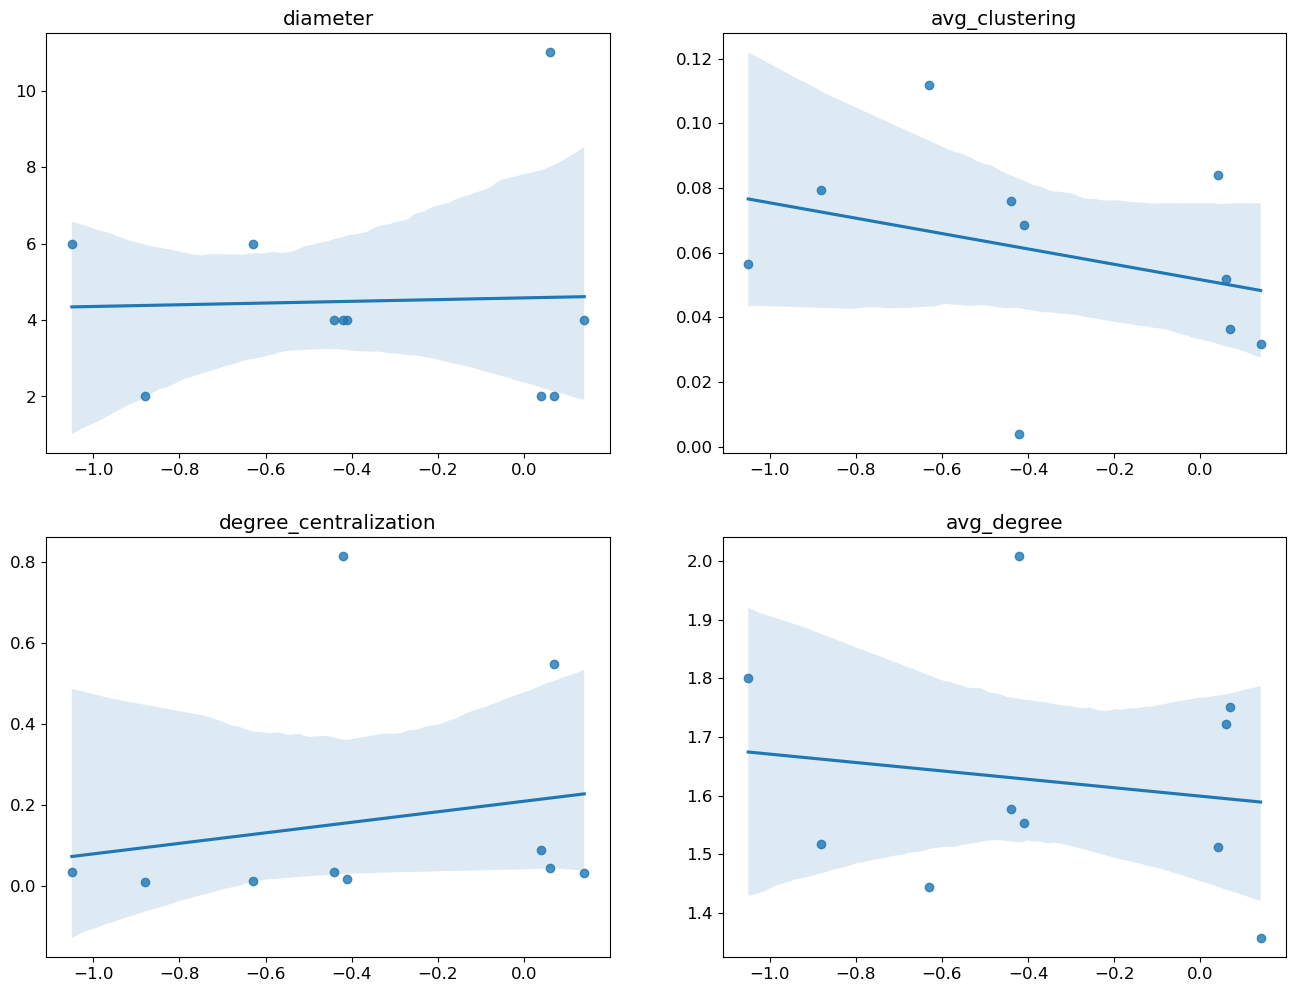

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

vars_to_plot = [
    'diameter',
    'avg_clustering',
    'degree_centralization',
    'avg_degree'
]

for i, var in enumerate(vars_to_plot):
    ax = axs[i // 2, i % 2]
    sns.regplot(data=metrics_df, x="rule_of_law", y=var, ax=ax)
    ax.set_title(var)
    ax.set_ylabel("")
    ax.set_xlabel("")


We're seeing something that's essentially indepedent

## Degree Distribution Analysis

Analyze the degree distribution of each country's network and compare it Erdos-Renyi and compare it to a power-law distribution 

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


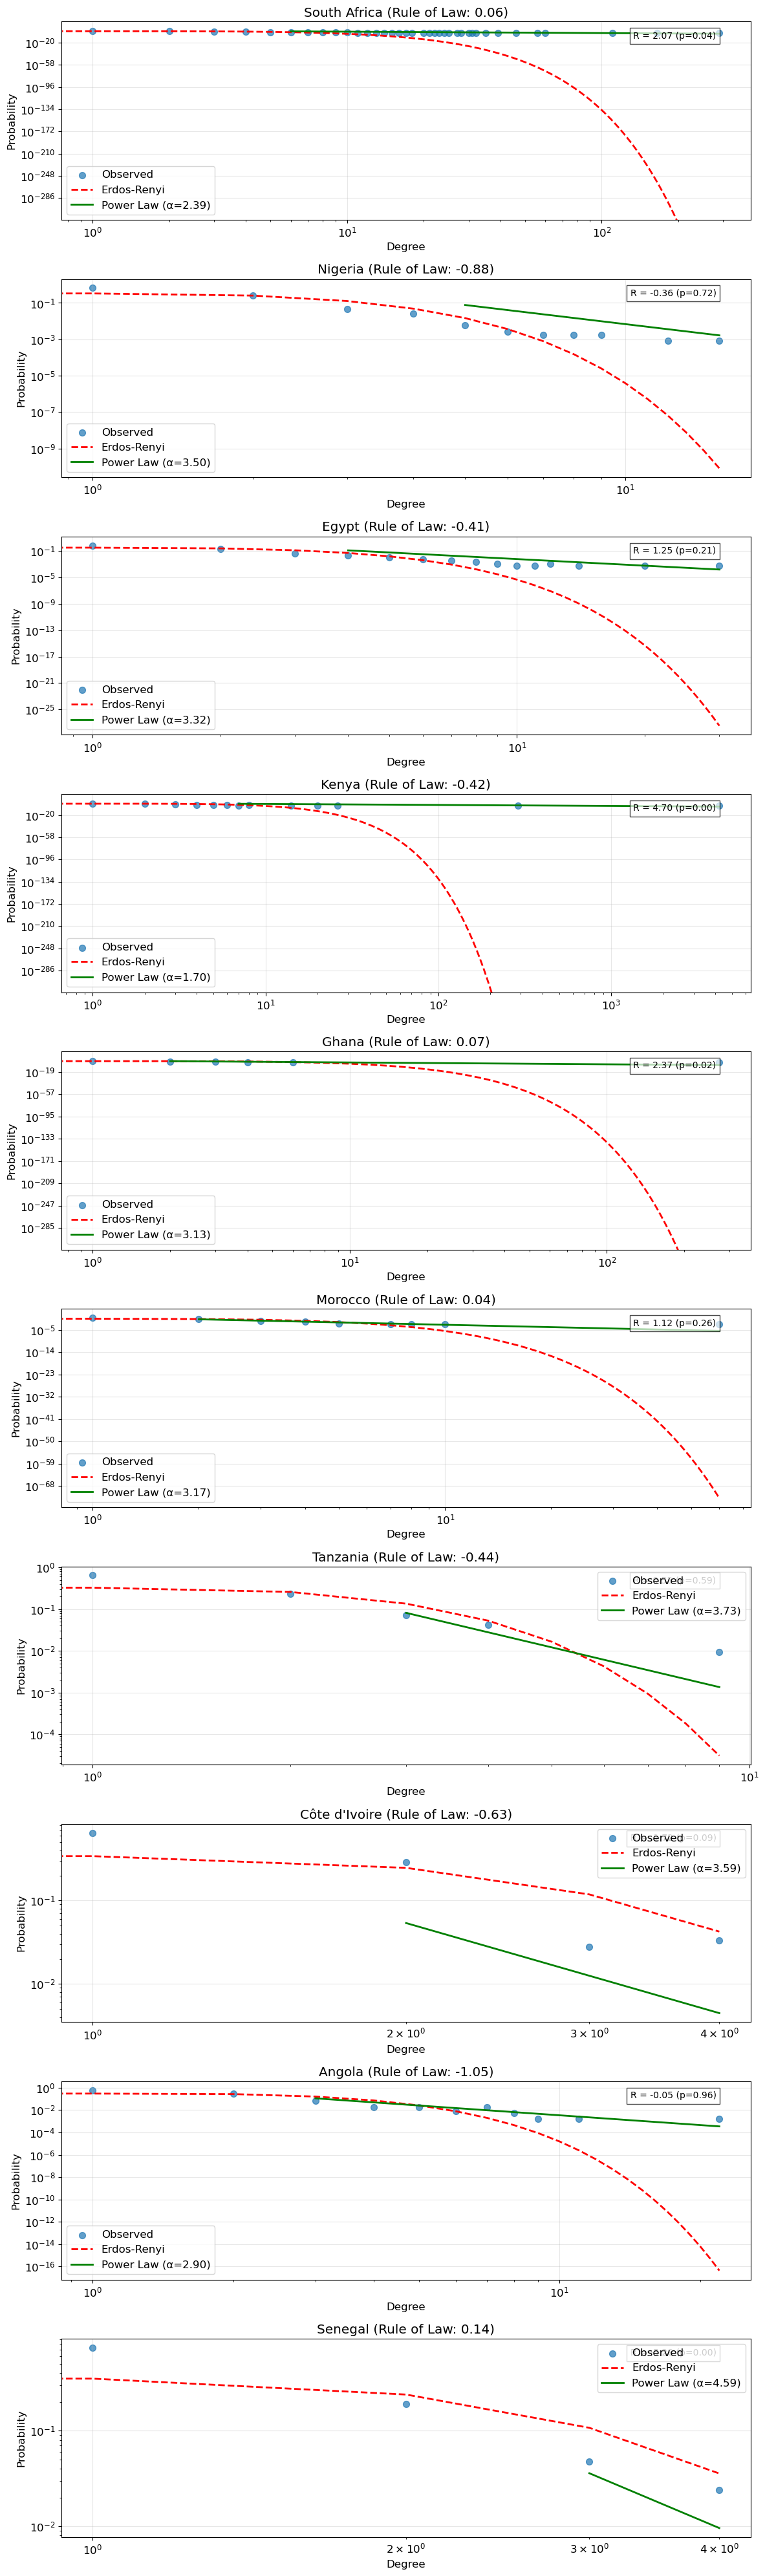

In [49]:
def plot_degree_distribution(G, title, ax=None, log_scale=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    
    degree_count = {}
    for d in degree_sequence:
        if d in degree_count:
            degree_count[d] += 1
        else:
            degree_count[d] = 1
    
    total_nodes = G.number_of_nodes()
    degree_prob = {d: count/total_nodes for d, count in degree_count.items()}
    
    degrees = sorted(degree_prob.keys())
    probs = [degree_prob[d] for d in degrees]
    
    ax.scatter(degrees, probs, alpha=0.7, s=50, label="Observed")
    
    p = nx.density(G)
    n = G.number_of_nodes()
    er_degrees = range(max(degrees) + 1)
    er_probs = [stats.binom.pmf(d, n-1, p) for d in er_degrees]
    ax.plot(er_degrees, er_probs, 'r--', linewidth=2, label="Erdos-Renyi")
    
    if len(degree_sequence) > 10:
        try:
            fit = powerlaw.Fit(degree_sequence, discrete=True)
            alpha = fit.power_law.alpha
            xmin = fit.power_law.xmin
            
            x = np.logspace(np.log10(xmin), np.log10(max(degrees)), 50)
            y = x**(-alpha) / sum(x**(-alpha))  # Normalized
            
            ax.plot(x, y, 'g-', linewidth=2, label=f"Power Law (α={alpha:.2f})")
            
            R, p_value = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
            ax.text(0.95, 0.95, f"R = {R:.2f} (p={p_value:.2f})", transform=ax.transAxes, 
                    verticalalignment='top', horizontalalignment='right', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7))
        except:
            pass
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    ax.set_xlabel('Degree')
    ax.set_ylabel('Probability')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

fig, axs = plt.subplots(len(country_codes), 1, figsize=(12, 4*len(country_codes)))

for i, country_code in enumerate(country_codes):
    G = country_networks[country_code]
    title = f"{countries[country_code]['name']} (Rule of Law: {countries[country_code]['rule_of_law']:.2f})"
    plot_degree_distribution(G, title, ax=axs[i])

plt.tight_layout()
plt.show()

Likewise, there's not really a heterogeneity in the kind of distribution of the degrees in the differnet countries - all pretty much look like a power-law distribution - at least far more comparable than an Erdos-Renyi model calibrated after it